資料來源：
先爬Reuters新聞網取得所需日期、標題和內文，存成Reuters_news.pickle

分析每則新聞內文的單字關聯性，找出中美貿易戰的特定議題，並想藉由不同程度正負面單字的使用推測新聞屬於正面消息或負面消息

In [2]:
import pandas as pd
import numpy as np
import pickle
import datetime

with open('Reuters_news.pickle', 'rb') as file:
    news_to_ana = pickle.load(file)

news_frame = pd.DataFrame(news_to_ana)[['date', 'title', 'summary', 'content']]
news_frame.head()

,date,title,summary,content
0,2018-09-18 08:24:00,China will use trade war with US to replace im...,"... measures"" the United States is taking in t...","SHANGHAI, Sept 19 (Reuters) - China is not afr..."
1,2019-05-13 04:28:00,US STOCKS-Wall St shudders as U.S.-China trade...,"... belligerent\ntrade war, sending investors ...",NEW YORK (Reuters) - Wall Street sank on Monda...
2,2019-05-13 02:38:00,US STOCKS-Wall St dives as U.S.-China trade wa...,.../ in a news window)\n* China to impose tari...,"(For a live blog on the U.S. stock market, cli..."
3,2018-10-12 04:02:00,Lenders brace for trade war,"...-China trade war intensifies, dealing a\nfu...",* Loans: Business from China to take further h...
4,2018-09-07 03:07:00,"Australian, NZ shares fall on worries US-China...","..., partly because of the\npossibility the U....",* Australian shares have worst week since Febr...


# 事件頻率

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

def barplot(x, y,x_label="", y_label="", title=""): 
    _, ax = plt.subplots()
    
    ax.bar(x,y, color="#7EB09B", align = 'center')
    ax.set_xlabel(x_label, fontsize=20)
    ax.set_ylabel(y_label, fontsize=20)
    ax.set_title(title)
    ax.xaxis.set_major_locator(ticker.MultipleLocator(30))
    plt.setp(ax.get_xticklabels(), rotation=70, horizontalalignment='right')


In [7]:
# check date data type
timeS = {'2018-09-18' : 0}
cnt = 0
for news in news_to_ana:
    while cnt != 5:
        datestr = news['date'].date().strftime('%Y-%m-%d')
        if datestr in timeS:
            print('Y')
        else:
            print('N')
        cnt += 1

Y
Y
Y
Y
Y


<Figure size 864x432 with 0 Axes>

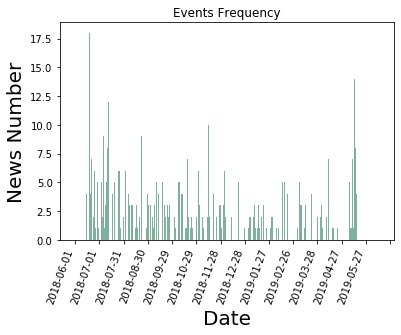

In [9]:
start = datetime.datetime(2018, 6, 1)
end = datetime.datetime.today()
step = datetime.timedelta(days=1)


timeSeries = {}
while start < end:
    timeSeries[start.strftime('%Y-%m-%d')] = 0
    start += step
#print(timeSeries)


for news in news_to_ana:    
    datestr = news['date'].date().strftime('%Y-%m-%d') #注意data type
    if datestr in timeSeries:
        timeSeries[datestr] += 1
#print(timeSeries)

fig = plt.figure(figsize = (12, 6))
barplot(timeSeries.keys(), timeSeries.values(), x_label = 'Date', y_label = 'News Number', title = 'Events Frequency')

觀察上面的事件發生頻率圖，可以發現，2018年六月、七月份以及2019年五月份為事件發生最頻繁的兩段時間，再比對中美貿易戰的時間軸，中美雙方確實在上述時段動作頻繁：
2018年6~7月：中美雙方公布對彼此的關稅清單
2019年5月：美國先行對中國加徵關稅，中國亦採取反制關稅，議題並延燒至華為事件

# TF-IDF文字預處理

In [4]:
corpus = news_frame['content'].values.tolist()

In [5]:
from sklearn.feature_extraction.text import CountVectorizer
vec = CountVectorizer()
X = vec.fit_transform(corpus) # 636(文章數量) x 13703(篩選過的單詞) matrix with 24828 stored elements #(文章序號，單詞序號) 出現頻率
word = vec.get_feature_names() #初步篩選文章中出現的單詞 len(word) = 13703

from sklearn.feature_extraction.text import TfidfTransformer  #過濾不重要但出現頻率高的單詞
transformer = TfidfTransformer()  
tfidf = transformer.fit_transform(X)
features = tfidf.toarray()

In [6]:
textFrame = pd.DataFrame(features, columns = word) #把處理過的詞頻回傳到對應的新聞
textFrame.head()
#len(features) #新聞有636則

,00,000,0025,003490,0045,007,01,011,0130,0131,...,zionist,ziying,zloty,zn,zone,zones,zozo,zte,zuckerberg,zwingle
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.096062,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0


In [7]:
allF = features.flatten() #將 636 x 13703的陣列將為一維陣列
nonZero = allF[np.nonzero(allF)] # np.nonzero(allF):返回所有非零值所在index，nonZero:返回對應的非零值
m = np.median(nonZero) #計算中位數
nonZero

array([0.04296435, 0.03284297, 0.033597  , ..., 0.03481953, 0.02431921,
       0.03804494])

In [8]:
m

0.03334547782991327

In [9]:
# 篩選「關鍵單字」
m = 0.08 # set threshold
dataset = []
for i in range(len(features)):
    temp = textFrame.columns.values[[textFrame.iloc[i] >= m]] #每個單詞的tf-idf值大於m >> 保留
    #print(temp)
    dataset.append(temp.tolist())
#print(len(dataset)) # 由636個 list(636 news)組成的大list

In [10]:
for i in range(len(features)):
    print(dataset[i])

['affiliated', 'afraid', 'and', 'by', 'china', 'daily', 'deeper', 'dove', 'edition', 'find', 'in', 'ineffective', 'instead', 'is', 'it', 'its', 'listings', 'localisation', 'measures', 'newspaper', 'of', 'on', 'opportunity', 'people', 'pressuring', 'products', 'promote', 'proper', 'recognition', 'replace', 'resilience', 'said', 'sept', 'solutions', 'squarely', 'succumb', 'tait', 'tech', 'the', 'to', 'trade', 'will']
['38', '41', '500', 'and', 'by', 'fell', 'fleeing', 'in', 'inc', 'lows', 'lyft', 'nasdaq', 'new', 'of', 'on', 'percentage', 'posted', 'posting', 'ratio', 'rourke', 'sank', 'the', 'to', 'uber']
['500', '54', 'and', 'by', 'culp', 'dow', 'drop', 'fell', 'fleeing', 'for', 'in', 'inc', 'industrials', 'jan', 'lows', 'nasdaq', 'new', 'of', 'on', 'or', 'percentage', 'rourke', 'stephen', 'the', 'to', 'uber', 'underwhelming']
['and', 'bank', 'banker', 'borrower', 'borrowers', 'chakravarti', 'china', 'computer', 'exposure', 'in', 'lam', 'lenders', 'loan', 'loans', 'of', 'prc', 'syndica

In [11]:
# Transform data
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(dataset).transform(dataset)
df = pd.DataFrame(te_ary, columns = te.columns_) 
df.rows = news_frame['title']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [12]:
df.head()

,00,000,0045,01,02,0200,03,034,038,04,...,zhao,zhong,zhou,zinc,ziying,zloty,zone,zozo,zte,zuckerberg
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


# 關連性分析：Apriori  

Support(X) = number(X) / number(AllSamples) 
表示itemset X在所有樣本中出現的頻率

Confidence(X -> Y) = P(Y|X) 
表示給定X發生，Y發生的機率

Lift(X -> Y) = P(Y|X) / P(Y) 
表示給定X發生，同時發生Y的可能性，且只看Y發生的機率，提升度反應了X與Y的關聯性，提升度>1或越高表示越相關，提升度=1表示為互相獨立，提升度<1或越低代表負相關性越高

In [13]:
from mlxtend.frequent_patterns import apriori
from mlxtend.frequent_patterns import association_rules

minsup = 0.2
#apriori(graph, min_support = minsup, use_colnames = True) # itemset: 新聞
apriori(df, min_support = minsup, use_colnames = True) # itemset: 單詞

,support,itemsets
0,0.819182,(and)
1,0.292453,(china)
2,0.823899,(in)
3,0.831761,(of)
4,0.498428,(on)
5,0.292453,(percent)
6,0.993711,(the)
7,0.926101,(to)
8,0.250000,"(and, china)"
9,0.707547,"(and, in)"


In [29]:
#因為出現頻率高的單詞都是介系詞、冠詞，並無分析意義，因此手動去除
to_del = ['and', 'in',  'the', 'to',  'of',  'on', 'by', 'for', 'as', 'at', 'he', 'that', 'is', 'it', 'its', 'has', 'are']
#cnt = 0
newset = []
for lst in dataset:
    #print(lst), cnt
    lst = [x for x in lst if x not in to_del]
    newset.append(lst)
    #print(lst, cnt)
    #cnt += 1
for i in range(len(features)):
    print(newset[i])

['affiliated', 'afraid', 'china', 'daily', 'deeper', 'dove', 'edition', 'find', 'ineffective', 'instead', 'listings', 'localisation', 'measures', 'newspaper', 'opportunity', 'people', 'pressuring', 'products', 'promote', 'proper', 'recognition', 'replace', 'resilience', 'said', 'sept', 'solutions', 'squarely', 'succumb', 'tait', 'tech', 'trade', 'will']
['38', '41', '500', 'fell', 'fleeing', 'inc', 'lows', 'lyft', 'nasdaq', 'new', 'percentage', 'posted', 'posting', 'ratio', 'rourke', 'sank', 'uber']
['500', '54', 'culp', 'dow', 'drop', 'fell', 'fleeing', 'inc', 'industrials', 'jan', 'lows', 'nasdaq', 'new', 'or', 'percentage', 'rourke', 'stephen', 'uber', 'underwhelming']
['bank', 'banker', 'borrower', 'borrowers', 'chakravarti', 'china', 'computer', 'exposure', 'lam', 'lenders', 'loan', 'loans', 'prc', 'syndicated', 'tmt', 'us', 'zte']
['0400', '095', '143', '7th', 'a2', 'asx', 'australia', 'australian', 'bank', 'banking', 'cba', 'dogged', 'february', 'galaxy', 'hearings', 'index', 'i

# 關鍵字詞頻

195
dict_keys(['china', 'percent', 'trade', 'said', 'points', 'pct', 'dollar', 'shares', 'year', 'farmers', 'nasdaq', 'down', 'tariffs', 'dow', 'soybean', 'stocks', 'was', 'with', 'will', 'index', 'yuan', 'soybeans', 'minis', 'trump', 'bank', 'million', 'tonnes', 'after', 'copper', 'talks', 'we', 'inc', 'chinese', 'prices', 'oil', 'growth', 'new', 'were', 'crude', 'farm', '500', 'ratio', 'week', 'investors', 'lng', 'live', 'earnings', 'billion', 'or', 'beijing', 'from', 'soy', 'gas', 'up', 'futures', 'pork', 'be', 'quarter', 'lme', 'european', 'fell', 'japan', 'monday', 'thursday', 'brazil', 'markets', 'forecast', 'yen', 'company', 'metals', 'deal', 'market', 'ministry', 'month', 'economy', 'exports', 'aluminium', 'firms', 'emerging', 'coal', 'fed', 'yields', 'apple', 'demand', 'currencies', 'currency', 'report', 'xi', 'amy', 'caren', 'daniel', 'profit', 'et', 'global', 'his', 'wto', 'euro', 'not', 'japanese', 'imports', 'shanghai', 'low', 'lowest', 'shankar', 'sruthi', 'pboc', 'steel'

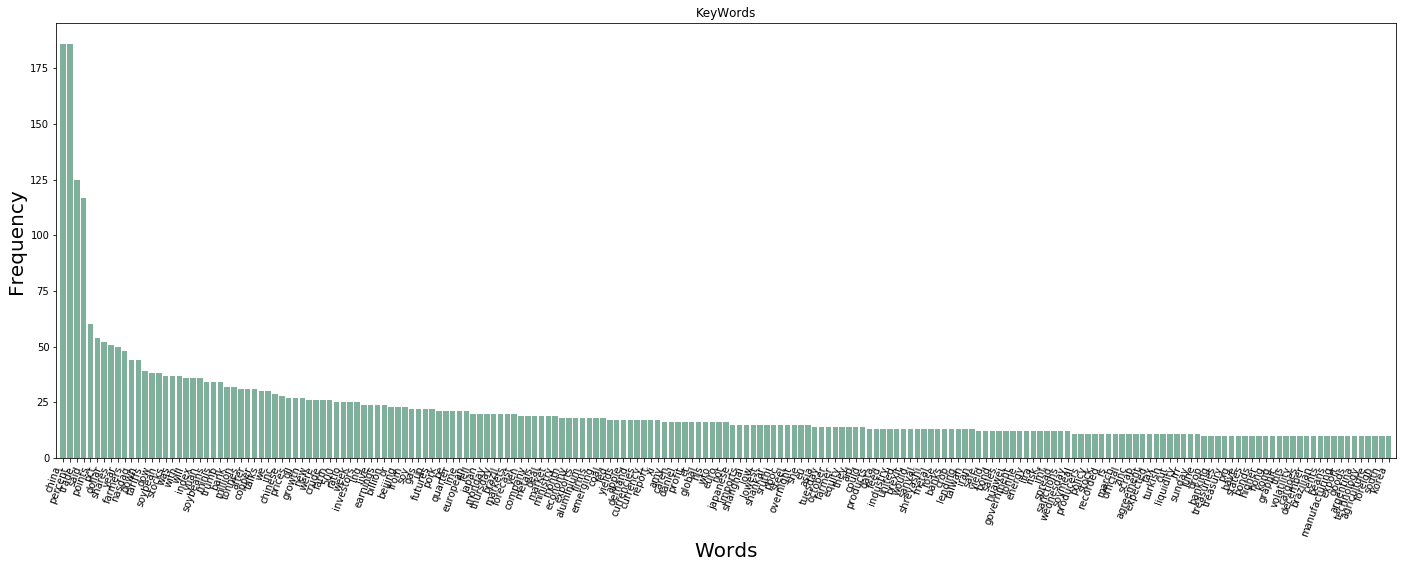

In [58]:
wrd_cnt = {}
for alist in newset:
    for wrds in alist:
        if wrds not in wrd_cnt:
            wrd_cnt[wrds] = 1
        else:
            wrd_cnt[wrds] += 1

key_wrds = {}
for vocab in wrd_cnt.keys():
    if wrd_cnt[vocab] >= 10:
        #print(vocab, wrd_cnt[vocab])
        key_wrds[vocab] = wrd_cnt[vocab]

sort_key_wrds = dict(sorted(key_wrds.items(), key= lambda x:x[1], reverse = True))
#print(sort_key_wrds)

barplot(sort_key_wrds.keys(), sort_key_wrds.values(), x_label = 'Words', y_label = 'Frequency', title = 'KeyWords')

plt.gcf().set_size_inches(24, 8)

print(len(sort_key_wrds))
print(sort_key_wrds.keys())

經過篩選得出的關鍵詞，可以初步看出中美貿易的影響：
1. 'shares', 'nasdaq',  'down',  'dow',  'stocks', 'investors'...：股市通常是最迅速反應消息的地方，可想而知，中美貿易對投資人必是操作的重要考量。
2. 'soybean',  'copper',  'gas', 'oil', 'coal', 'aluminium', 'agriculture', 'technology', 'huawei'：根據中美雙方貿易的往來，可以發現農業、能源類產業以及高科技產業等常常是新聞的討論焦點。

In [59]:
#  Transform data
from mlxtend.preprocessing import TransactionEncoder

te = TransactionEncoder()
te_ary = te.fit(newset).transform(newset)
df2 = pd.DataFrame(te_ary, columns = te.columns_) 
#graph = df.T # transpose
#graph.columns = news_frame['title']
df2.rows = news_frame['title']

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:9: UserWarning: Pandas doesn't allow columns to be created via a new attribute name - see https://pandas.pydata.org/pandas-docs/stable/indexing.html#attribute-access
  if __name__ == '__main__':


In [60]:
df2.head()

,00,000,0045,01,02,0200,03,034,038,04,...,zhao,zhong,zhou,zinc,ziying,zloty,zone,zozo,zte,zuckerberg
0,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,True,False
4,False,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [66]:
# 利用支持度篩選關鍵詞
minsup = 0.02
#apriori(graph, min_support = minsup, use_colnames = True) # itemset: 新聞
result = apriori(df2, min_support = minsup, use_colnames = True) # itemset: 單詞
result

,support,itemsets
0,0.039308,(500)
1,0.048742,(after)
2,0.022013,(aid)
3,0.028302,(aluminium)
4,0.025157,(amy)
5,0.026730,(apple)
6,0.022013,(asia)
7,0.050314,(bank)
8,0.020440,(banks)
9,0.033019,(be)


In [68]:
rules = association_rules(result, metric="confidence", min_threshold=0.7)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(after),(percent),0.048742,0.292453,0.039308,0.806452,2.757544,0.025053,3.655660
1,(aluminium),(copper),0.028302,0.048742,0.020440,0.722222,14.817204,0.019061,3.424528
2,(aluminium),(lme),0.028302,0.033019,0.020440,0.722222,21.873016,0.019506,3.481132
3,(amy),(caren),0.025157,0.025157,0.025157,1.000000,39.750000,0.024524,inf
4,(caren),(amy),0.025157,0.025157,0.025157,1.000000,39.750000,0.024524,inf


In [73]:
rules = association_rules(result, metric="lift", min_threshold=3)
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction
0,(dow),(500),0.059748,0.039308,0.022013,0.368421,9.372632,0.019664,1.521095
1,(500),(dow),0.039308,0.059748,0.022013,0.560000,9.372632,0.019664,2.136935
2,(inc),(500),0.045597,0.039308,0.020440,0.448276,11.404138,0.018648,1.741254
3,(500),(inc),0.039308,0.045597,0.020440,0.520000,11.404138,0.018648,1.988339
4,(nasdaq),(500),0.069182,0.039308,0.026730,0.386364,9.829091,0.024010,1.565572


In [75]:
rules["antecedent_len"] = rules["antecedents"].apply(lambda x: len(x))
rules.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
0,(dow),(500),0.059748,0.039308,0.022013,0.368421,9.372632,0.019664,1.521095,1
1,(500),(dow),0.039308,0.059748,0.022013,0.560000,9.372632,0.019664,2.136935,1
2,(inc),(500),0.045597,0.039308,0.020440,0.448276,11.404138,0.018648,1.741254,1
3,(500),(inc),0.039308,0.045597,0.020440,0.520000,11.404138,0.018648,1.988339,1
4,(nasdaq),(500),0.069182,0.039308,0.026730,0.386364,9.829091,0.024010,1.565572,1


In [78]:
# 設定最終篩選條件
out = rules[ (rules['antecedent_len'] >= 2) &
       (rules['confidence'] > 0.5) &
       (rules['lift'] > 3) ]
out.head()

,antecedents,consequents,antecedent support,consequent support,support,confidence,lift,leverage,conviction,antecedent_len
154,"(copper, aluminium)",(lme),0.020440,0.033019,0.020440,1.000000,30.285714,0.019765,inf,2
155,"(copper, lme)",(aluminium),0.028302,0.028302,0.020440,0.722222,25.518519,0.019639,3.498113,2
156,"(aluminium, lme)",(copper),0.020440,0.048742,0.020440,1.000000,20.516129,0.019444,inf,2
160,"(daniel, amy)",(caren),0.025157,0.025157,0.025157,1.000000,39.750000,0.024524,inf,2
161,"(daniel, caren)",(amy),0.025157,0.025157,0.025157,1.000000,39.750000,0.024524,inf,2


Support Mean:         0.02595   Support Median:         0.02358
Confidence Mean:    0.57030   Confidence Median:    0.54167
Sample:  834


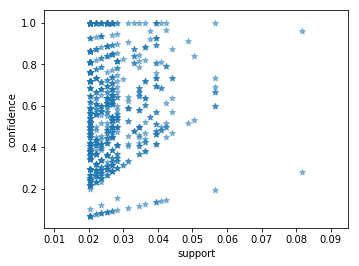

In [79]:
support = rules['support']
confidence = rules['confidence']

fig = plt.figure(figsize=(12, 4))
ax1 = plt.subplot(121)

ax1.scatter(support, confidence, alpha=0.5, marker="*") #alpha : 設定透明度
ax1.set_xlabel('support')
ax1.set_ylabel('confidence') 

print("Support Mean: %15.5f" % support.mean(), "  Support Median: %15.5f" % support.median())
#print("Lift Mean: %21.5f" % lift.mean(), "  Lift Median: %22.5f" % lift.median())
print("Confidence Mean: %10.5f" % confidence.mean(), "  Confidence Median: %10.5f" % confidence.median())
print("Sample: ", np.shape(rules)[0])

# 視覺化：共現圖

我們再進一步呈現關鍵詞之間的關聯性，找出特定議題

In [80]:
import networkx as nx
G = nx.DiGraph() #建立一個空graph，有方向性
for i in range(len(news_frame)):
    G.add_node(i) #80則新聞：80個nodes
for i in range(len(rules['antecedents'])):
    currentFrom = list(rules['antecedents'][i])
    currentTo = list(rules['consequents'][i])
    #print(currentFrom[0], currentTo[0])
    G.add_edge(currentFrom[0], currentTo[0])
    '''for j in range(len(currentFrom)):
        G.add_edge(currentFrom[j], currentTo[0]) #currentTo是只含一個單詞的list
        #print(currentFrom[0], currentTo[0])'''

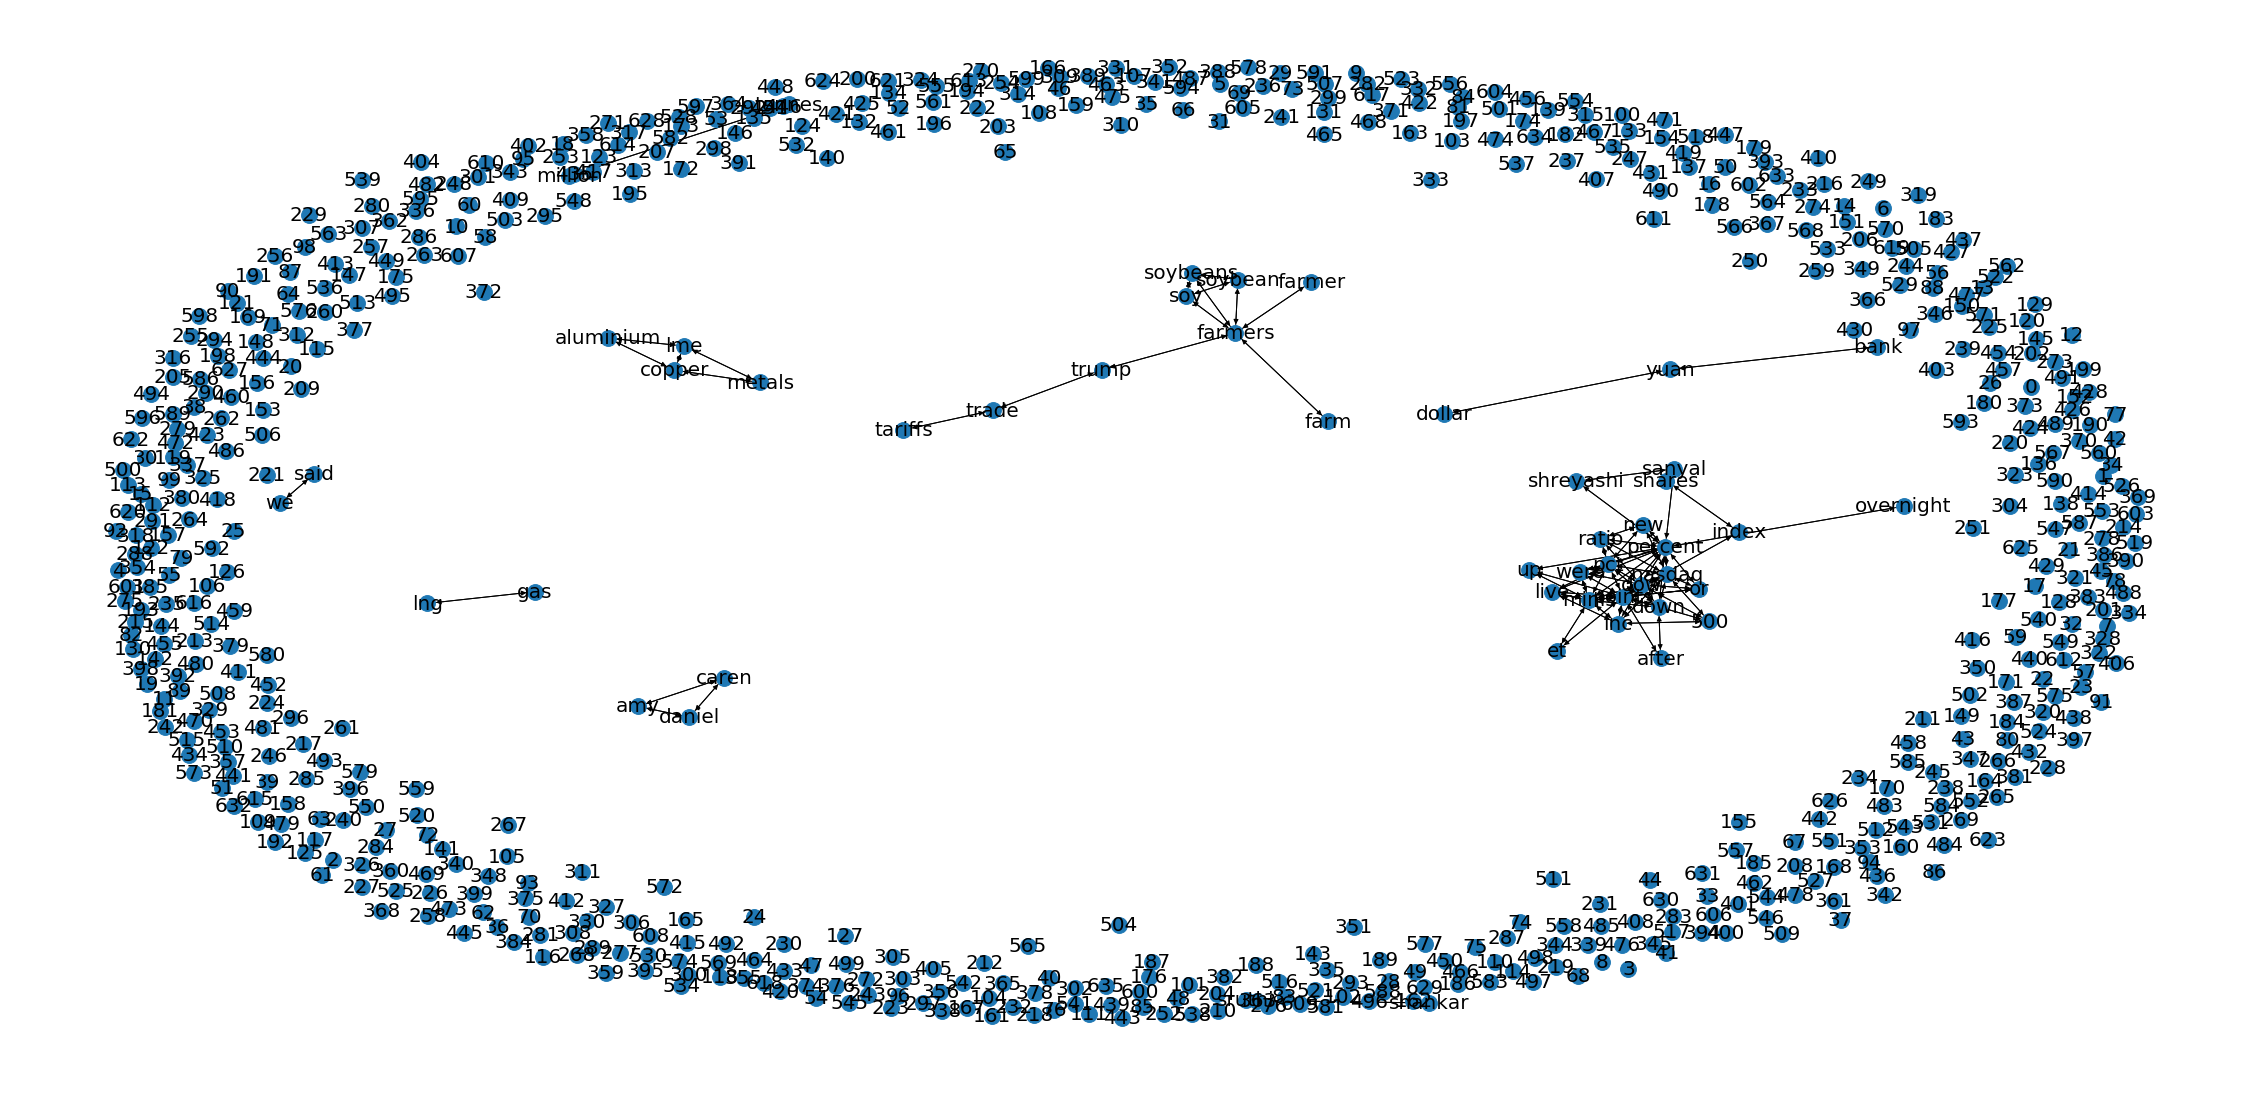

In [89]:
plt.figure(figsize=(40,20))

# positions for all nodes
pos = nx.fruchterman_reingold_layout(G, k=0.2)

# nodes
nx.draw_networkx_nodes(G, pos, node_size=250)
nx.draw_networkx_edges(G, pos, width=1)

# labels
nx.draw_networkx_labels(G,pos,font_size=20,font_family='sans-serif')

plt.axis('off')
#plt.savefig("weighted_graph.png") # save as png
plt.show()

結論：共現圖呈現關鍵詞群聚的現象，能看出某些重點議題：
1.  {'aluminium', 'LME', 'copper', 'metals'}：中美貿易戰使得倫敦金屬交易所(LME)基本金屬期貨下跌
2. {'LNG', 'gas'}：中國提高液化天然氣(LNG)關稅，並減緩對其採購
3. {'soy', 'soybeans'}：中國是美國大豆最大進口國，因此貿易戰對美國大豆得影響甚鉅
4. {'nasdaq', 'down'}, {'dow', '500'}：可見貿易戰對美國股市造成劇烈震盪
5. {'dollar', 'yuan', 'bank'}：貿易戰和美元、人民幣匯率息息相關


In [92]:
from networkx.algorithms.approximation import dominating_set
dominating_set.min_edge_dominating_set(G)

{('amy', 'caren'),
 ('bank', 'yuan'),
 ('copper', 'aluminium'),
 ('dow', '500'),
 ('farm', 'farmers'),
 ('gas', 'lng'),
 ('inc', 'live'),
 ('index', 'shares'),
 ('lme', 'metals'),
 ('minis', 'et'),
 ('nasdaq', 'down'),
 ('or', 'percent'),
 ('pct', 'new'),
 ('points', 'after'),
 ('sanyal', 'shreyashi'),
 ('shankar', 'sruthi'),
 ('soy', 'soybean'),
 ('tonnes', 'million'),
 ('trump', 'trade'),
 ('we', 'said')}